## Importing breast cancer dataset
Use the pip commands if keras and tf are out of sync

In [261]:
#pip show 

In [262]:
#pip install --upgrade tensorflow==2.8.1

In [263]:
#pip install keras==2.8.0

The content of the breast cancer dataset is:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
-------------------------
inputs =  (569, 30)
outputs =  (569,)
labels =  (30,)


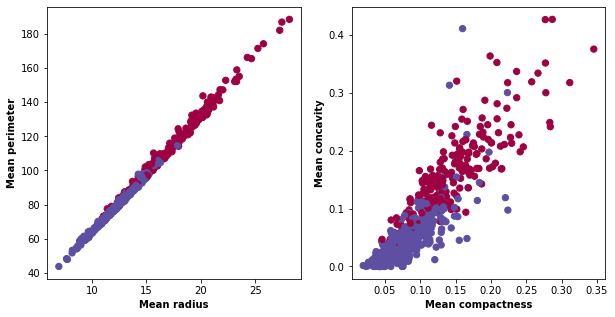

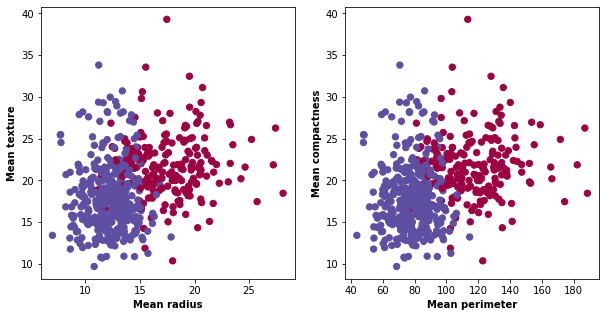

In [264]:
### Code for importing and treating dataset borrowed from lect notes (14.11.22)

import tensorflow.python as tf
from tensorflow.python import keras
from keras.layers import Input
from keras.models import Sequential      #This allows appending layers to existing models
from keras.layers import Dense           #This allows defining the characteristics of a particular layer
from keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
#from keras.utils import plot_model   #This allows using categorical cross entropy as the cost function
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import pickle
import os
from sklearn.metrics import accuracy_score
from p2_functions import MSE, create_X, sigmoid, RELU, to_categorical_numpy
from FFNN_classes import FFNN_Classification


"""Load breast cancer dataset"""

np.random.seed(0)        #create same seed for random number every time

cancer=load_breast_cancer()      #Download breast cancer dataset

inputs=cancer.data                     #Feature matrix of 569 rows (samples) and 30 columns (parameters)
outputs=cancer.target                  #Label array of 569 rows (0 for benign and 1 for malignant)
labels=cancer.feature_names[0:30]

print('The content of the breast cancer dataset is:')      #Print information about the datasets
print(labels)
print('-------------------------')
print("inputs =  " + str(inputs.shape))
print("outputs =  " + str(outputs.shape))
print("labels =  "+ str(labels.shape))

x=inputs      #Reassign the Feature and Label matrices to other variables
y=outputs

# Visualisation of dataset (for correlation analysis)

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 2], s=40, c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean radius', fontweight='bold')
plt.ylabel('Mean perimeter', fontweight='bold')

plt.subplot(1, 2, 2)
plt.scatter(x[:, 5], x[:, 6], s=40, c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean compactness', fontweight='bold')
plt.ylabel('Mean concavity', fontweight='bold')
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean radius', fontweight='bold')
plt.ylabel('Mean texture', fontweight='bold')

plt.subplot(1, 2, 2)
plt.scatter(x[:, 2], x[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean perimeter', fontweight='bold')
plt.ylabel('Mean compactness', fontweight='bold')
plt.show()

## Classification FFNN script

In [265]:
# Generate training and testing datasets

# Select features relevant to classification (texture,perimeter,compactness and symmetery)
# and add to input matrix

temp1 = np.reshape(x[:, 1], (len(x[:, 1]), 1))
temp2 = np.reshape(x[:, 2], (len(x[:, 2]), 1))
X = np.hstack((temp1, temp2))
temp = np.reshape(x[:, 5], (len(x[:, 5]), 1))
X = np.hstack((X, temp))
temp = np.reshape(x[:, 8], (len(x[:, 8]), 1))
X = np.hstack((X, temp))

# Split data into training and testing sets (0.8, 0.2 respectively)
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y).reshape(-1,1), test_size=0.2) 

del temp1, temp2, temp

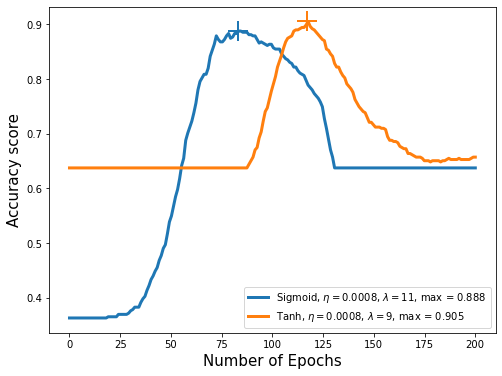

In [266]:
plt.figure(figsize = (8, 6))
plt.xlabel('Number of Epochs', fontsize = 15)
plt.ylabel('Accuracy score', fontsize = 15)

cnn1 = FFNN_Classification(X_train, y_train, activation = 'Sigmoid', eta = 0.0008, lmbd = 11, epochs = 200,
                          n_hidden_neurons = 20)
e1, a1, p1, c1 = cnn1.train()

cnn2 = FFNN_Classification(X_train, y_train, activation = 'Tanh', eta = 0.0008, lmbd = 9, epochs = 200,
                          n_hidden_neurons = 30)
e2, a2, p2, c2 = cnn2.train()

# plot maxima
indx1 = np.argmax(a1)
plt.scatter(indx1, a1[indx1], s = 400, zorder = 2, marker = '+', lw = 2)
indx2 = np.argmax(a2)
plt.scatter(indx2, a2[indx2], s = 400, zorder = 2, marker = '+', lw = 2)
plt.legend()#; plt.savefig('CancerAcc') 
plt.show()

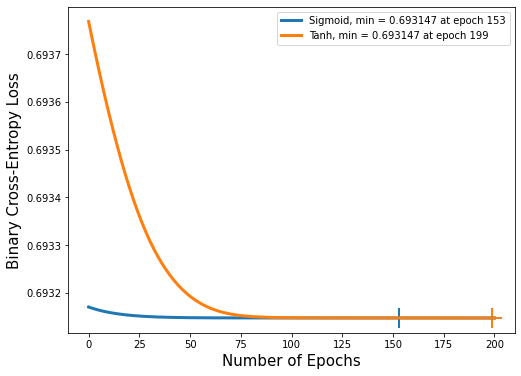

In [267]:
plt.figure(figsize = (8, 6))
plt.xlabel('Number of Epochs', fontsize = 15)
plt.ylabel('Binary Cross-Entropy Loss', fontsize = 15)

# plot minima
indx1 = np.argmin(c1)
plt.scatter(indx1, c1[indx1], s = 400, zorder = 2, marker = '+', lw = 2)
indx2 = np.argmin(c2)
plt.scatter(indx2, c2[indx2], s = 400, zorder = 2, marker = '+', lw = 2)

plt.plot(e1, c1, lw = 3, label = f'Sigmoid, min = {round(c1[indx1], 6)} at epoch {indx1}')
plt.plot(e2, c2, lw = 3, label = f'Tanh, min = {round(c2[indx2], 6)} at epoch {indx2}')
plt.legend()#; plt.savefig('CancerLoss')
plt.show()

## Hyperparameter analysis

### (Keras classification network)

In [276]:
# Creating the same architecture
model = Sequential()
# Hidden layer and input
model.add(Dense(20, input_dim = len(X_train[0,:]), kernel_initializer='random_normal', 
                activation = 'sigmoid', kernel_regularizer = regularizers.L1(1)))
#output layer
model.add(Dense(1, activation = 'softmax'))

print(y_train.shape)
#print(X_train[:,0])

# Compile, fit and evaluate
#opt = optimizers.SGD(learning_rate=0.5)
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 50, batch_size = 0, verbose = 0)
loss, acc = model.evaluate(X_test, y_test)
print(f'Validation score: {acc}')

(455, 1)
4/4 [==============================] - 0s 2ms/step - loss: 1.0514 - accuracy: 0.5877
Validation score: 0.5877193212509155


Runs when setting features as input. We get the same accuracy every run (0.5877), definitely wrong. Can't use optimizer due to compatibility issues with tf and keras. 

## Scikit learn classification network

Validation score = 0.5877192982456141


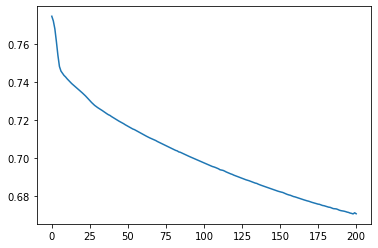

In [274]:
from sklearn.neural_network import MLPClassifier

n_hidden_neurons = 20
epochs = 200
modl = MLPClassifier(solver = 'sgd', activation = 'logistic', hidden_layer_sizes = n_hidden_neurons, 
                     alpha = 11, learning_rate_init = 0.0008, random_state = 0, max_iter = epochs, 
                    n_iter_no_change = 1000)
modl.fit(X_train, y_train)
loss = getattr(modl, 'loss_curve_')
itr = getattr(modl, 'n_iter_')
print(f'Validation score = {modl.score(X_test, y_test)}')

epoch = np.linspace(0, itr, itr)
plt.plot(epoch, loss)

## Logistic regression of cancer data (task E)

In [270]:
# first using sklearn method
from sklearn.linear_model import LogisticRegression

model_ = LogisticRegression()
model_.fit(X_train, y_train.ravel())
model_.predict(X_test)
print(f'Accuracy score: {model_.score(X_test, y_test)}')

Accuracy score: 0.9122807017543859


In [271]:
# our own code ...